In [61]:
%cd ~/src/laboratori/1112

/home/jovyan/src/laboratori/1112


# **Introduzione al Machine Learning -- laboratorio 11 e 12**

Stimatori di massima verosimiglianza

Importa le librerie necessarie (numpy, matplotlib, pandas, seaborn) e la distribuzione esponenziale da `scipy.stats`. Genera un campione casuale `sample` di dimensione `n=50` da una distribuzione esponenziale con media `mean=3.5`. Visualizza i punti del campione generato.

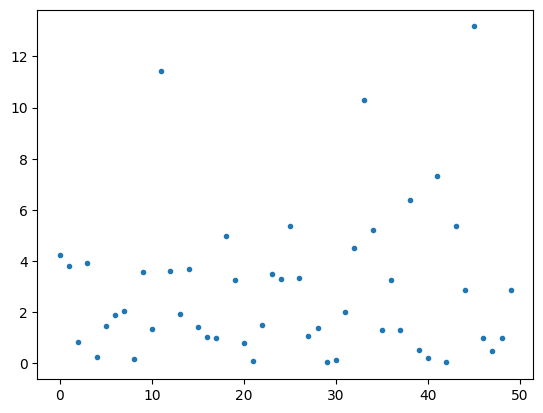

In [62]:
# Generiamo un campione con legge esponenziale assegnata e calcoliamo la likelihood.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import expon

n = 50
mean = 3.5

sample = expon.rvs(scale=mean, size=n)
plt.plot(sample, '.')
plt.show()

Definisce una funzione `log_likelihood(mu, sample)` che calcola la log-verosimiglianza del campione `sample` per una data media `mu`, assumendo una distribuzione esponenziale. Crea un range di possibili valori per `mu` (usando scala logaritmica `geomspace`) e traccia il grafico della log-verosimiglianza in funzione di `mu`.

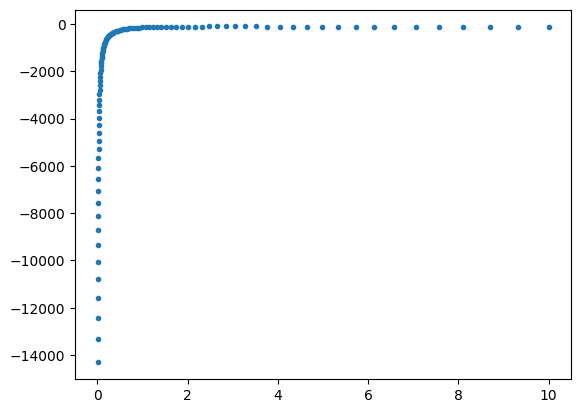

In [63]:
# Calcoliamo la log-likelihood

def log_likelihood(mu, sample):
  return expon.logpdf(sample, scale=mu).sum()

mu_range = np.geomspace(0.01, 10, 100)
plt.plot(mu_range, [log_likelihood(mu, sample) for mu in mu_range], '.')
plt.show()

Traccia nuovamente il grafico della log-verosimiglianza (sia come linea che come punti). Aggiunge un punto rosso in corrispondenza della media campionaria (`sample.mean()`) e del valore della log-verosimiglianza calcolato in quel punto. Questo illustra che la media campionaria è lo stimatore di massima verosimiglianza per il parametro di scala (media) della distribuzione esponenziale. Imposta i limiti dell'asse y per una migliore visualizzazione.

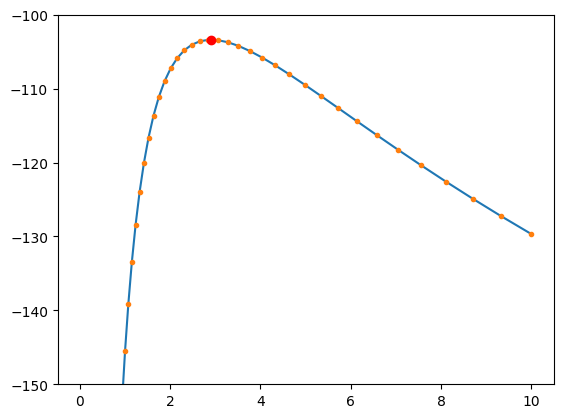

In [64]:
plt.plot(mu_range, [log_likelihood(mu, sample) for mu in mu_range])
plt.plot(mu_range, [log_likelihood(mu, sample) for mu in mu_range], '.')

plt.plot(sample.mean(), log_likelihood(sample.mean(), sample), 'or') # La media corrisponde allo stimatore di massimo somiglianza
plt.ylim([-150, -100])
plt.show()

Definisce una funzione `loss` come il negativo della log-verosimiglianza, trasformando il problema di massimizzazione in uno di minimizzazione. Traccia il grafico della funzione `loss` rispetto a `mu` e imposta i limiti dell'asse y.

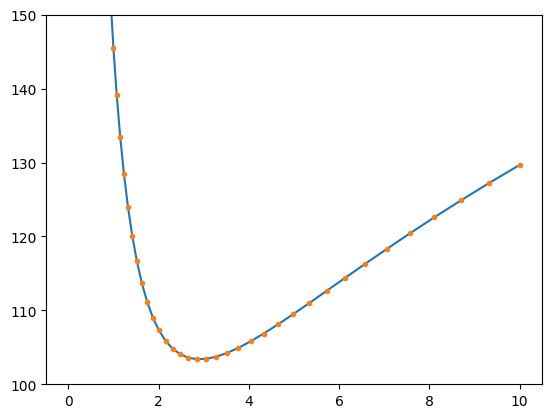

In [65]:
# Mi serve una funzione da minimizzare, invece che massimizzare

loss = lambda mu, sample: -log_likelihood(mu, sample)

plt.plot(mu_range, [loss(mu, sample) for mu in mu_range])
plt.plot(mu_range, [loss(mu, sample) for mu in mu_range], '.')
plt.ylim([100, 150])
plt.show()

Importa `minimize_scalar` da `scipy.optimize`. Utilizza questa funzione per trovare il valore di `mu` che minimizza la funzione `loss`, passando il campione `sample` come argomento aggiuntivo. Stampa il risultato dell'ottimizzazione.

In [66]:
# Cerchiamo il minimo
from scipy.optimize import minimize_scalar
result = minimize_scalar(loss, args=(sample,))
print(result)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 103.38819896692922
       x: 2.908867956817335
     nit: 11
    nfev: 15


/opt/conda/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Visualizza la media campionaria (`sample.mean()`), il valore di `mu` trovato dall'ottimizzazione (`result.x`) e il valore minimo della funzione `loss` (`result.fun`) per confrontarli.

In [67]:
sample.mean(), result.x, result.fun

(np.float64(2.908867933890374),
 np.float64(2.908867956817335),
 np.float64(103.38819896692922))

Definisce una nuova funzione `loss_scalar` che accetta solo `mu` come argomento (il campione `sample` è fissato). Utilizza `minimize_scalar` con l'opzione `bounds` per specificare un intervallo entro cui cercare il minimo (metodo 'bounded'). Stampa il risultato.

In [68]:
# Posso fare anche in quest'altro modo
loss_scalar = lambda mu: -log_likelihood(mu, sample)

res1 = minimize_scalar(loss_scalar, bounds=(2, 6)) # bounds given -> bounded method
print(res1)

 message: Solution found.
 success: True
  status: 0
     fun: 103.38819896692985
       x: 2.908868390852183
     nit: 12
    nfev: 12


Utilizza `minimize_scalar` con l'opzione `bracket` per specificare un intervallo che contiene il minimo (metodo di Brent). Stampa il risultato.

In [69]:
res2 = minimize_scalar(loss_scalar, bracket=(2, 6)) # braket given -> Brendt method
print(res2)

 message: The algorithm terminated without finding a valid bracket. Consider trying different initial points.
 success: False
     fun: nan
       x: nan
     nit: 0
    nfev: 3


Ottimizzazione in più variabili

Importa la distribuzione Gamma da `scipy.stats`. Genera un campione casuale `data_gamma` di dimensione `n=50` da una distribuzione Gamma con parametri di forma `alpha=1.5` e scala `beta=42`. Visualizza un istogramma dei dati generati.

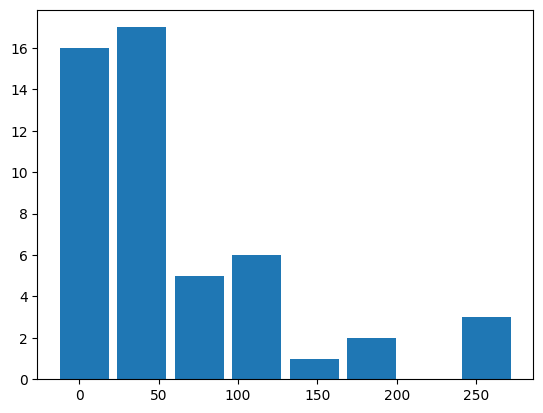

In [70]:
from scipy.stats import gamma

n = 50
alpha = 1.5
beta = 42

data_gamma = gamma.rvs(a=alpha, scale=beta, size=n)
plt.hist(data_gamma, bins='auto', align='left', rwidth=0.85)
plt.show()

Visualizza i punti del campione `data_gamma` generato.

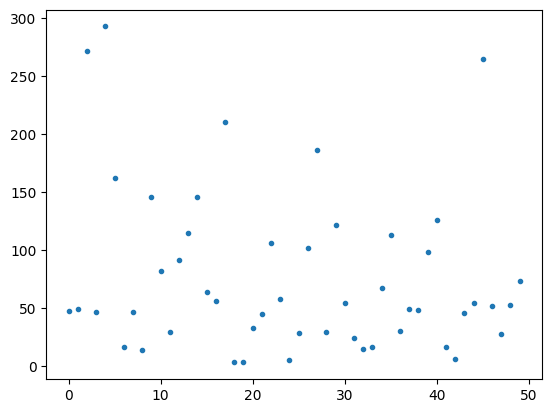

In [71]:
plt.plot(data_gamma, '.')
plt.show()

Crea un range di valori `x` e traccia la funzione di densità di probabilità (PDF) della distribuzione Gamma con i parametri `alpha` e `beta` usati per generare i dati.

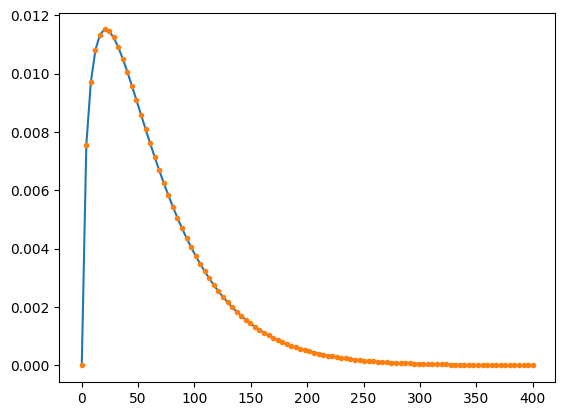

In [72]:
# Vediamo il grafico della pdf

x = np.linspace(0, 400, 100)
plt.plot(x, gamma.pdf(x, a=alpha, scale=beta))
plt.plot(x, gamma.pdf(x, a=alpha, scale=beta), '.')
plt.show()

Definisce una funzione `loss_gamma(params, data)` che calcola il negativo della log-verosimiglianza per la distribuzione Gamma, dati i parametri `alpha` e `beta` (passati come `params`) e il campione `data`. Crea una funzione `loss_gamma_wrapped` che fissa il campione `data_gamma` per l'ottimizzazione.

In [73]:
# Scriviamo la loss

def loss_gamma(params, data):
  alpha, beta = params
  return -gamma.logpdf(data, a=alpha, scale=beta).sum()

loss_gamma_wrapped = lambda params: loss_gamma(params, data_gamma)

Importa `minimize` da `scipy.optimize`. Utilizza questa funzione per trovare i parametri `alpha` e `beta` che minimizzano la funzione `loss_gamma_wrapped`, partendo da una stima iniziale `x0=[1, 1]`. Stampa il risultato dell'ottimizzazione multivariata.

In [74]:
# Minimizzo la loss
from scipy.optimize import minimize

res = minimize(loss_gamma_wrapped, x0=[1, 1])
print(res)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 266.2891477948313
        x: [ 1.272e+00  6.047e+01]
      nit: 27
      jac: [ 4.959e-05  3.815e-06]
 hess_inv: [[ 1.995e-02 -1.004e-02]
            [-1.004e-02  9.227e-03]]
     nfev: 108
     njev: 36


Importa `Axes3D` per grafici 3D. Crea una griglia di valori per `alpha` (X) e `beta` (Y). Calcola i valori della funzione `loss_gamma_wrapped` (Z) su questa griglia. Crea un grafico 3D della superficie della funzione di loss.

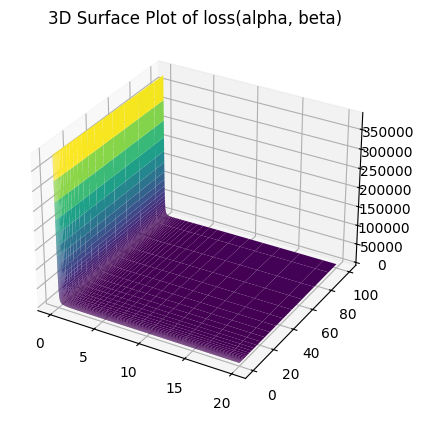

In [75]:
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of (x, y) values
X = np.geomspace(0.01, 20, 100)
Y = np.geomspace(0.01, 100, 100)

# Define the function
Z = np.array([loss_gamma_wrapped([x, y]) for x in X for y in Y]).reshape((len(X), len(Y)))
X, Y = np.meshgrid(X, Y)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_zlim([100,10000])
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('3D Surface Plot of loss(alpha, beta)')
plt.show()

Sfrutta la relazione tra i parametri della Gamma e la media campionaria (`xbar = alpha * beta`) per esprimere `beta` in funzione di `alpha` (`beta = xbar / alpha`). Definisce una nuova funzione di loss `loss_gamma_scalar` che dipende solo da `alpha`, semplificando l'ottimizzazione a una sola variabile.

In [76]:
# Posso semplificare la procedura di ottimizzazione, se risolvo esattamente beta in funzione di alpha

xbar = data_gamma.mean()

beta = lambda alpha: xbar / alpha
loss_gamma_scalar = lambda  alpha: loss_gamma_wrapped([alpha, beta(alpha)])

Crea un range di valori per `alpha` e traccia il grafico della funzione di loss `loss_gamma_scalar` rispetto ad `alpha`.

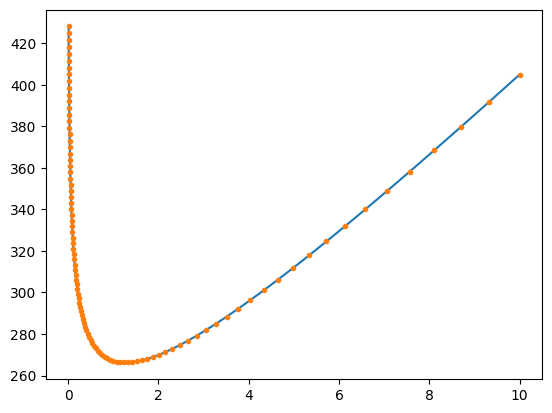

In [77]:
alpha_range = np.geomspace(0.01, 10, 100)
plt.plot(alpha_range, [loss_gamma_scalar(alpha) for alpha in alpha_range])
plt.plot(alpha_range, [loss_gamma_scalar(alpha) for alpha in alpha_range], '.')
plt.show()

Utilizza `minimize_scalar` per trovare il valore di `alpha` che minimizza `loss_gamma_scalar`, specificando dei limiti (`bounds`). Stampa il risultato.

In [78]:
res1 = minimize_scalar(loss_gamma_scalar, bounds=(0.1, 10)) # bounds given -> bounded method
print(res1)

 message: Solution found.
 success: True
  status: 0
     fun: 266.2891477944707
       x: 1.271825930200278
     nit: 13
    nfev: 13


Definisce una nuova funzione di loss `loss_log_gamma` che prende in input il logaritmo di `alpha`. Questo trasforma il vincolo `alpha > 0` in un problema senza vincoli per `log_alpha`. Esegue l'ottimizzazione su `loss_log_gamma` usando `minimize_scalar`. Calcola le stime di massima verosimiglianza `alpha_hat` e `beta_hat` dal risultato e le stampa.

In [79]:
# Posso anche fare in modo che l'argomento non abbia vincoli

loss_log_gamma = lambda log_alpha: loss_gamma_scalar(np.exp(log_alpha))

res2 = minimize_scalar(loss_log_gamma)
print(res2)
log_alpha = res2.x
alpha_hat = np.exp(log_alpha)
beta_hat = beta(alpha_hat)

print(f'{alpha_hat=:g},  {beta_hat=:g}')

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 266.2891477944704
       x: 0.24045373766305944
     nit: 15
    nfev: 18
alpha_hat=1.27183,  beta_hat=60.4672


Importa `pandas`. Legge il primo foglio ('sheet_name=0') del file Excel 'synthetic_sample_generation.xlsx' in un DataFrame `df` e lo visualizza.

In [80]:
# Carico la prima scheda del file excel

import pandas as pd

filename = 'synthetic_sample_generation.xlsx'

df = pd.read_excel(filename, sheet_name=0)
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000
0,nu,1.334647,1.172535,1.248412,1.36543,1.06997,0.766827,0.338499,0.60849,1.625765,...,0.637977,0.474451,1.109622,1.172687,0.650288,0.66669,0.560875,0.89542,0.738677,0.708506
1,cluster,9.000000,8.000000,2.000000,5.00000,2.00000,3.000000,5.000000,10.00000,2.000000,...,2.000000,8.000000,9.000000,7.000000,1.000000,1.00000,2.000000,8.00000,5.000000,8.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0610007N19Rik,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000,0.000000
4,0610007P14Rik,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12571,l7Rn6,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
12572,mmu-mir-7067,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
12573,mmu-mir-7666,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
12574,n-R5s115,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000


Rimuove le prime tre righe del DataFrame `df` (che potrebbero contenere metadati o intestazioni non utili) usando `iloc` e visualizza il DataFrame risultante.

In [81]:
# Butto via le prime tre righe

df = df.iloc[3:, :]
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000
3,0610007N19Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0610007P14Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0610009B22Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0610009D07Rik,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0610009E02Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12571,l7Rn6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12572,mmu-mir-7067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12573,mmu-mir-7666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12574,n-R5s115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Imposta la prima colonna del DataFrame (contenente i nomi dei geni) come indice delle righe usando `set_index`. Memorizza il risultato in `df_clean` e lo visualizza.

In [82]:
# Assegno come indici di riga i nomi dei geni, nella prima colonna

df_clean = df.set_index(df.columns[0])
df_clean

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0610007N19Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0610007P14Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0610009B22Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009D07Rik,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009E02Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l7Rn6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mmu-mir-7067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mmu-mir-7666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sostituisce i nomi delle colonne esistenti con una sequenza di numeri interi da 0 a 999 (assumendo 1000 colonne). Visualizza il DataFrame `df_clean` con le nuove intestazioni di colonna.

In [83]:
# Sostituisco i nomi delle colonne con numeri da 0 a 999

df_clean.columns = list(range(1000))
df_clean

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0610007N19Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0610007P14Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0610009B22Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009D07Rik,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009E02Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l7Rn6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mmu-mir-7067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mmu-mir-7666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ottiene il numero di geni (`ngenes`) e il numero di cellule (`ncell`) dalle dimensioni del DataFrame `df_clean` e li stampa.

In [84]:
ngenes, ncell = df_clean.shape
print(ngenes, ncell)

12573 1000


Inizializza i parametri per un modello di espressione genica basato sulla distribuzione binomiale negativa. `a` (dispersione) e `mu` (livello medio di espressione) dipendono dal gene, mentre `t` (fattore di scala/libreria) dipende dalla cellula. Vengono inizializzati come array di uni.

In [85]:
# Uso un modello in cui a dipende dal gene e nu=mu*t con mu dipendente dal gene e t dalla cellula

a  = np.ones(ngenes)
mu = np.ones(ngenes)
t  = np.ones(ncell)


Importa la distribuzione binomiale negativa (`nbinom`) da `scipy.stats`. Definisce la funzione `loss_rna(a, mu, t)` che calcola il negativo della log-verosimiglianza per i dati di conteggio RNA-seq (`df_clean`) sotto il modello binomiale negativo. I parametri `r` e `p` della distribuzione sono calcolati a partire da `a`, `mu` e `t`.

In [86]:
# Definisco la loss in funzione dei parametri, usando la binomiale negativa

from scipy.stats import nbinom

def loss_rna(a, mu, t):
    nu = mu.reshape(-1, 1) * t.reshape(1, -1)
    a = a.reshape(-1, 1)
    r = 1/a
    p = 1/(1+a*nu)
    return -nbinom.logpmf(df_clean, r, p).sum()

Calcola e visualizza il valore iniziale della funzione di loss `loss_rna` utilizzando i parametri inizializzati `a`, `mu`, `t`.

In [88]:
loss_rna(a, mu, t)

np.float64(9958230.667478763)